In [6]:
import cv2 as cv
import matplotlib.pyplot as plt
import json
import cmath
import math
import numpy as np   
import glob

In [7]:
from Vi_cA_13 import Ring_Processer

In [12]:
center = (0,0)
def find_distance(x):
    cx,cy = (x[0][0]+x[1][0])/2,(x[0][1]+x[1][1])/2
    print(cx,cy)
    return math.sqrt((cx-center[0])**2+(cy-center[1])**2)

In [13]:
a = [[[1,2],[3,4]],[[3,5],[3,4]]]
list(map(find_distance,a))
     

2.0 3.0
3.0 4.5


[3.605551275463989, 5.408326913195984]

In [15]:
["abv","aas"]+["aaa"]

['abv', 'aas', 'aaa']

## 得到原图和box，圆半径，圆心信息

In [70]:
img_info_dir = "./word_fake_data/"
img_list = [cv.imread(path) for path in glob.glob(img_info_dir+"*.png")]
img_json_path = [path for path in glob.glob(img_info_dir+"*.json")]

In [71]:
"""
获取一张图的bbox_list信息 [[[xmin,ymin],[xmax,ymax]],[[..],[..]]]
""" 
def get_bbox_list(img_json_path,i):
    path = img_json_path[i]
    bbox_list = []
    with open(path,'r',encoding='utf8')as fp:
        json_data = json.load(fp)
    for item in json_data["shapes"]:
        if item["label"]=="word":
            bbox_list.append(item["points"])
    return bbox_list

In [72]:
"""
获取一张图的半径，圆心信息
"""
def get_radius_center(img):
    ring_obj = Ring_Processer(img)
    circles = ring_obj.circle_list
    r_inner = circles[2][2]
    r_outer = circles[3][2]
    center = ring_obj.get_center(circles)
#     print(circles)
#     print(center)
    return r_inner,r_outer,center

In [73]:
index = 0
img = img_list[index]
bbox_list = get_bbox_list(img_json_path,index)
r_inner,r_outer,center = get_radius_center(img)


In [74]:
bbox_list

[[[910.569105691057, 1069.1056910569105],
  [1008.130081300813, 1150.4065040650407]],
 [[886.9918699186992, 1190.2439024390244],
  [973.9837398373984, 1272.357723577236]],
 [[3041.7582417582416, 1371.4285714285713],
  [3139.010989010989, 1430.2197802197802]],
 [[3034.065934065934, 1478.5714285714284],
  [3132.967032967033, 1547.8021978021977]],
 [[3026.3736263736264, 1588.4615384615383],
  [3117.5824175824173, 1656.043956043956]],
 [[2998.901098901099, 1692.857142857143],
  [3090.6593406593406, 1768.131868131868]],
 [[2957.6923076923076, 1782.4175824175823],
  [3053.846153846154, 1854.9450549450548]],
 [[2937.912087912088, 1863.7362637362637],
  [3025.8241758241757, 1951.098901098901]],
 [[2872.5274725274726, 1966.4835164835165],
  [2965.3846153846152, 2046.7032967032967]]]

In [75]:
r_inner

1023.2509460449219

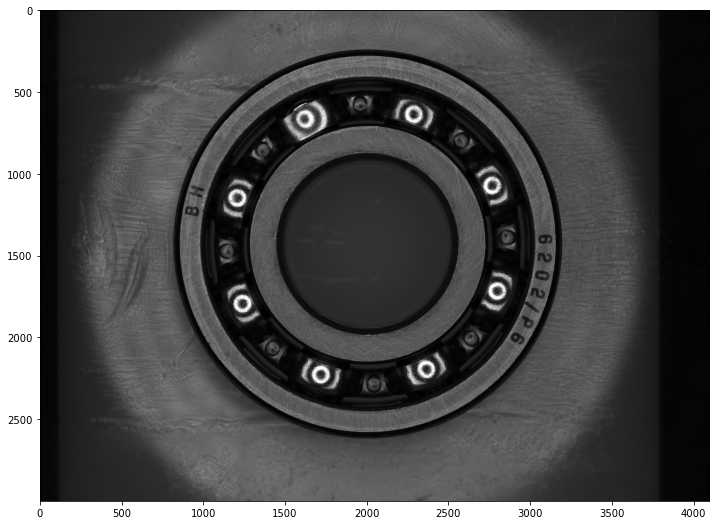

In [8]:
fig = plt.figure(figsize=(12,12))
plt.imshow(img)

In [41]:
# #index 为11 修改r_inner,r_outer
# index = 11
# img = img_list[index]
# bbox_list = get_bbox_list(img_json_path,index)
# r_inner,r_outer,center = get_radius_center(img)
# fig = plt.figure(figsize=(12,12))
# ring_obj = Ring_Processer(img)
# circles = ring_obj.circle_list
# r_inner = circles[0][2]
# r_outer = circles[1][2]
# plt.imshow(img)

## 得到聚类后的信息

In [42]:
'''
得到字符的中心点
输入：相关最大最小值信息
输出：中心点坐标
'''
def getCharacterCenterByInfo(Info):
#     Info = getInfo(box)
    result = [(Info[0]+Info[2])/2,(Info[1]+Info[3])/2]
#     result = [int(i) for i in result]
    return result

In [43]:
'''
得到一张的所有字符的相对位置
一个字符的位置表示 在图中的中心位置坐标 相对圆心的角度 长度（角度为角度值）
input：所有字符的box 圆中心坐标center
return 所有字符的位置信息
'''
########################
def get_img_character_position(bbox_list,center):
    img_character_infolist = []
    for item in bbox_list:
        xyxy = item[0]+item[1]
        CharacterCenter = getCharacterCenterByInfo(xyxy)
        xy =  (CharacterCenter[0]-center[0],center[1]-CharacterCenter[1]) #得到字符中心点相对圆心的直角坐标
        cn = complex(xy[0],xy[1])
        r,angle = cmath.polar(cn)  #返回长度和弧度
#         if(angle<0):
#             angle += 2*math.pi 
        angle = angle/math.pi*180
        img_character_infolist.append([CharacterCenter,angle,r,xyxy])
    return img_character_infolist

In [44]:
'''
显示图片
输入：图片矩阵，画布大小：元组（宽，高）
'''
def showImg(img,figsize=(12,12),cmap = None):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(img,cmap = cmap)
    plt.show()

In [45]:
# obj01 = bbox_list[0]
# temp = img.copy()
# cv.rectangle(temp, (int(obj01[0][0]), int(obj01[0][1])), (int(obj01[1][0]), int(obj01[1][1])), (0, 0, 255), 8)
# showImg(temp)

In [46]:
"""
list 实际上应该是一个首尾相连的结构
可以指定index 找到其下一个或者上一个元素的下标
input: 下标 列表长度 是否找寻下一个 T则找寻下一个 F则找寻上一个
return：返回指定元素的下/上元素
"""
def index_next(index,length,next_index=True):
    if (next_index):
        index_another = index+1
        if(index_another==length):index_another = 0
    if not(next_index):
        index_another = index-1
        if(index_another==-1):index_another = length-1
    return index_another
"""
找寻指定的上，下夹角 
input: 保存角度的list index  next_index
return: next_index为真则返回与顺时针的相邻元素的夹角 为反则是返回逆时针夹角
"""
def inter_angle(img_position,index,next_index=True):
    index_another = index_next(index,len(img_position),next_index)
    angle = abs(img_position[index][1]-img_position[index_another][1])
    if(angle>180):
        angle = 360-angle
    return angle 
"""
通过img的位置信息进行聚类 聚类的角度标准为thresh 
input: img_position保存字符【【[x,y],xita,r】,【...】】 中心点 角度 半径的信息 thread:夹角小于thresh判定为一类
return:聚类后的列表
"""
def cluster_character(img_position,thresh=15):
    img_position = sorted(img_position,key=lambda x:(x[1]),reverse=True)
    start_index = 0
    length = len(img_position)
    result_list = []
    while(inter_angle(img_position,start_index,False)<thresh): #找寻开头元素
        start_index = index_next(start_index,length,False)
        
    select_index = index_next(start_index,length) #待聚类的元素
    result = [img_position[start_index]]
    while(True):
        if(inter_angle(img_position,select_index,False)<thresh): #小于指定角度则添加
            result.append(img_position[select_index])
        else:
            result_list.append(result)                           #否则此区域结束 
            result = [img_position[select_index]]
        select_index = index_next(select_index,length)
        if(select_index==start_index):
            result_list.append(result)
            break
    return result_list

In [47]:
img_position = get_img_character_position(bbox_list,center)
cluster_character_list = cluster_character(img_position,thresh=15)

In [48]:
r_width = r_outer-r_inner
r_width

107.14886474609375

In [49]:
def get_arc_length(angle,radius):
    return radius*(angle/180*math.pi)

In [50]:
radius = r_inner+(r_outer-r_inner)/2
radius

857.5698852539062

In [51]:
cluster_character_list

[[[[1203.0219780219782, 1655.4945054945056],
   -163.97400323247706,
   864.5396275406703,
   [1159.89010989011,
    1623.6263736263736,
    1246.1538461538462,
    1687.3626373626373]],
  [[1184.065934065934, 1571.7032967032965],
   -169.67175459705084,
   863.894542701177,
   [1140.6593406593406,
    1542.3076923076922,
    1227.4725274725274,
    1601.098901098901]],
  [[1176.923076923077, 1489.5604395604396],
   -175.14857021199953,
   860.1210359609423,
   [1133.5164835164835,
    1462.087912087912,
    1220.3296703296703,
    1517.032967032967]],
  [[1175.5494505494505, 1403.8461538461538],
   179.13424220125023,
   858.5111536886826,
   [1131.8681318681317,
    1374.7252747252746,
    1219.2307692307693,
    1432.967032967033]],
  [[1182.142857142857, 1333.7912087912086],
   174.43296807326777,
   855.8564864273023,
   [1134.6153846153845,
    1304.9450549450548,
    1229.6703296703297,
    1362.6373626373627]],
  [[1185.7142857142858, 1259.8901098901097],
   169.51865160065566,

In [54]:
min(cluster_character_list[0],key = lambda x:x[3][0])[3][0]

1131.8681318681317

In [44]:
str_bbox_list = []
for cluster in cluster_character_list:
    tbox0 = cluster[0][3]
    tbox1 = cluster[len(cluster)-1][3]
    xmin = min(tbox0[0],tbox1[0])
    ymin = min(tbox0[1],tbox1[1])
    xmax = max(tbox0[2],tbox1[2])
    ymax = max(tbox0[3],tbox1[3])
    str_bbox_list.append([xmin,ymin,xmax,ymax])
print(str_bbox_list)

[[1159.89010989011, 952.7472527472527, 1331.8681318681317, 1687.3626373626373], [2174.7252747252746, 529.1208791208791, 2621.4285714285716, 798.3516483516484], [2751.6129032258063, 1595.6989247311826, 2910.752688172043, 1853.763440860215], [2351.8367346938776, 2106.530612244898, 2512.6530612244896, 2235.1020408163263]]


In [60]:
get_arc_length(8,radius)

185.09540557788418

In [59]:
1.7*r_width

201.27568359375

## 通过将聚类的信息点将数字切割剪裁

In [116]:
'''
计算绕中心点旋转角度 顺时针为负 逆时针为正
输入：中心点的[x,y] 圆心坐标[x,y]
输出：旋转度数
'''
def calcAngle(point,center):
    angle = 0
    xdis = center[0]-point[0]
    ydis = center[1]-point[1]
    if(xdis!=0 and ydis!=0):
        tempAngle = math.atan(abs(xdis)/abs(ydis))*180/math.pi
        if(xdis>0 and ydis>0):
            angle = -(tempAngle) #右旋
        if(xdis<0 and ydis>0):
            angle = tempAngle
        if(xdis>0 and ydis<0):
            angle = tempAngle-180
        if(xdis<0 and ydis<0):
            angle = 180-tempAngle
    if(xdis==0 and ydis<0):
        angle = 180
    if(ydis==0 and xdis>0):
        angle = -90
    if(ydis==0 and xdis<0):
        angle = 90
    return angle

In [117]:
'''
根据图片中心点，和指定的正方形边长得到剪裁的图片
输入：图像，多边形的中心点的坐标：list形式[x,y]，指定
输出：剪裁好的图片
'''
def getCroppedBycenter(img,CharacterCenter,Rlength):
    CharacterCenter = [int(i) for i in CharacterCenter]
    span = int(Rlength/2)
    cropped = img[CharacterCenter[1]-span:CharacterCenter[1]+span,CharacterCenter[0]-span:CharacterCenter[0]+span]
    return cropped

In [118]:
#角度为负，顺时针；角度为正，逆时针
'''
得到旋转后图片
输入：剪裁图片和旋转角度
输出：将剪裁图片旋转angle的图像
'''
def rotateImg(cropped,angle=0,pad=0,borderValue = 0):
    rows,cols = cropped.shape[:2]
    # cols-1 and rows-1 are the coordinate limits.
    M = cv.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),angle,1)
    dst = cv.warpAffine(cropped,M,(cols+pad,rows+pad),borderValue=(borderValue,borderValue,borderValue))
    return dst

In [119]:
'''
通过圆心，字符中心点得到切割矫正后的图片
输入：圆心坐标：[x,y],多边形框的顶点位置：[[x,y],...],旋转后填充的长宽像素值 Rlength=剪裁的边长
输出：剪裁矫正后的字符图像
'''
def getPatternByCenter(img,circleCenter,characterCenter,Rlength,pad=0,boderValue = 0):
    angle = calcAngle(characterCenter,circleCenter) #图片的圆心坐标 旋转角度
    cropped = getCroppedBycenter(img,characterCenter,Rlength)    #得到剪裁的字符图片
    result = rotateImg(cropped,angle,pad,boderValue)
    return result

#### 设置

In [120]:
'''
根据聚类好的信息 剪裁旋转字符图片
输入：cluster_character_list（聚类好的字符信息）,boderValue=0在旋转后的边缘填充像素值，ratio=0.9 表示剪裁的大小依据 （半径差的ratio倍）
输出：raw_group_list：表示裁剪并旋转后返回的聚类好的图片列表
'''
def get_raw_group(cluster_character_list,img,center,Rlength=200, cropRlength=100, boderValue=0):
    raw_group_list = []
    circleCenter = center 
    Cstart = int((Rlength - cropRlength)/2)
    Cend = int(Cstart+cropRlength)
    for cluster in cluster_character_list:
        raw_group = []
        for character_info in cluster:
            characterCenter = character_info[0]
            result = getPatternByCenter(img,circleCenter,characterCenter,Rlength,boderValue=boderValue) #self.img
            result = result[Cstart:Cend,Cstart:Cend]
            raw_group.append(result)
        raw_group_list.append(raw_group)
    return raw_group_list

In [121]:

def get_raw_character_grouplist(img,bbox_list,r_inner,r_outer,center,ratio=0.9):
    img_position = get_img_character_position(bbox_list,center)
    cluster_character_list = cluster_character(img_position,thresh=15)
    cropRlength = int(ratio*(r_outer-r_inner)) #self
    Rlength = 2*cropRlength
    raw_group_list = get_raw_group(cluster_character_list,img,center,Rlength,cropRlength)
    return raw_group_list

## 查看聚类剪裁好的图片

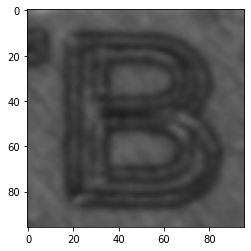

In [179]:
# plt.imshow(raw_group_list[0][9])
i = 0
for x in raw_group_list:
    for imgtemp in x:
        cv.imwrite("./temp/"+str(i)+".jpg",imgtemp)
        i+=1

### 正则表达式

In [ ]:
def revise_re(re_list):
    re_revise_list = []
    for pattern in re_list:
        re_revise = ""
        for char in pattern:
            if (char in ('0','D','O')):
                re_revise += "[0DO]"
            elif (char in ('7','T')):
                re_revise += "[7T]"
            elif (char in ('S','5')):
                re_revise += "[S5]"
            elif (char in ('Z','2')):
                re_revise += "[Z2]"
            elif (char in ('9','Q')):
                re_revise += "[0DO]"
            elif (char in ('1','I')):
                re_revise += "[1I]"
            elif not(char.isalnum()):
                re_revise += "."
            else:
                re_revise += char
        re_revise_list.append(re_revise)
    return re_revise_list 
def get_redetect_info(pattern_list,result_list):
    """
    检测字符匹配的情况
    input: pattern_list:提供的正则表达式列表 result_list 网络检测的字符串列表
    return: message:对比之后返回的检测信息
    """
    def revise_re(re_list):
        """
        修改提供的正则表达式
        input: re_list 待修改的字符串列表
        return：re_revise_list 修改后的字符串列表
        """
        re_revise_list = []
        for pattern in re_list:
            re_revise = ""
            for char in pattern:
                if (char in ('0','D','O')):
                    re_revise += "[0DO]"
                elif (char in ('7','T')):
                    re_revise += "[7T]"
                elif (char in ('S','5')):
                    re_revise += "[S5]"
                elif (char in ('Z','2')):
                    re_revise += "[Z2]"
                elif (char in ('9','Q')):
                    re_revise += "[0DO]"
                elif (char in ('1','I')):
                    re_revise += "[1I]"
                elif not(char.isalnum()):
                    re_revise += "."
                else:
                    re_revise += char
            re_revise_list.append(re_revise)
        return re_revise_list 
    
    pattern_list = revise_re(pattern_list)
    message = "匹配成功"
    if(len(result_list)!=len(pattern_list)):
        message = "子串个数不匹配"
        return message
    
    for item in result_list:
        flag = False
        for pattern in pattern_list:
            match_obj = re.match(pattern,item)
            
            if (match_obj):
                print(match_obj.group())
                flag = True
                break
        if not flag:
            message = "匹配子串出错"
            break
    return message
result_list = ['12307JPZ111',"1/3D&JPZ","BH"]
pattern_list = ["12307JPZ","1/3D/JPZ","B"]  
message = get_redetect_info(pattern_list,result_list)
print(message)

## 类形式

In [1]:
import cmath
import math
import cv2 as cv
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import timm
import cv2
import time
import re

In [4]:
class ViTBase16(nn.Module):
    def __init__(self,n_classes,pretrained = False):
        super(ViTBase16,self).__init__()
        self.model = timm.create_model("resnet34",pretrained=pretrained,in_chans =1,num_classes=n_classes)
    def forward(self,x):
        x = self.model(x)
        x = x.argmax(dim=1)
        return x

In [25]:
class CC:
    def __init__(self,weights_path,distribution_classes,pretrained = False):
        n_classes = len(distribution_classes)
        self.model = ViTBase16(n_classes=n_classes,pretrained=pretrained) #模型为实例化 ViTBase16
        self.model.load_state_dict(torch.load(weights_path))
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()  #!
#         if self.device.type=="cuda":
#             self.model.to(device)
        self.distribution_classes = distribution_classes
    @staticmethod
    def process(group):
        img_list = []
        resize = transforms.Resize([224,244])
        toTensor = transforms.ToTensor()
        for img in group:
            img = img.numpy()
            if img.ndim!=2:
                img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #转化为灰度图
            #二值化
#             blur = cv.GaussianBlur(img,(5,5),0)
#             ret,thImg = cv.threshold(blur,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)  
#             mask = cv.erode(thImg.astype('uint8'), kernel=np.ones((3,3)))
            mask = img
            #resize and normalize
            mask = Image.fromarray(mask)
            mask = toTensor(resize(mask)) 
            img_list.append(mask.numpy())
        return torch.tensor(img_list) 
    
    def get_pred_str(self,group):
        img_list = CC.process(group)
        if self.device.type=="cuda":
            img_list = img_list.cuda()
        output = self.model(img_list)
        result = ""
        for index in output:
            result += self.distribution_classes[index] 
        return result

In [2]:
class ViTBase16(nn.Module):
    def __init__(self,n_classes,pretrained = False):
        super(ViTBase16,self).__init__()
        self.model = timm.create_model("resnet34",pretrained=pretrained,in_chans =1,num_classes=n_classes)
    def forward(self,x):
        x = self.model(x)
        x = x.argmax(dim=1)
        return x
class binary_str:
    def __init__(self,weights_path,distribution_classes,pretrained = False):
        n_classes = len(distribution_classes)
        self.model = ViTBase16(n_classes=n_classes,pretrained=pretrained) #模型为实例化 ViTBase16
        self.model.load_state_dict(torch.load(weights_path))
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()  #!
#         if self.device.type=="cuda":
#             self.model.to(device)
        self.distribution_classes = distribution_classes
    @staticmethod
    def process(group):
        img_list = []
        resize = transforms.Resize([224,244])
        toTensor = transforms.ToTensor()
        for img in group:
            img = img.numpy()
            if img.ndim!=2:
                img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #转化为灰度图
            #二值化
#             blur = cv.GaussianBlur(img,(5,5),0)
#             ret,thImg = cv.threshold(blur,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)  
#             mask = cv.erode(thImg.astype('uint8'), kernel=np.ones((3,3)))
            mask = img
            #resize and normalize
            mask = Image.fromarray(mask)
            mask = toTensor(resize(mask)) 
            img_list.append(mask.numpy())
        return torch.tensor(img_list) 
    
    def get_pred_str(self,group):
        img_list = binary_str.process(group)
        if self.device.type=="cuda":
            img_list = img_list.cuda()
        output = self.model(img_list)
        result = ""
        for index in output:
            result += self.distribution_classes[index] 
        return result

In [28]:
distribution_classes = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
weights_path = "./models/resnet34.pt"
word_classifier = Word_Classification(weights_path,distribution_classes)

In [5]:
from torch.utils.data import DataLoader, Dataset
import os,glob
distribution_classes = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
weights_path = "./models/resnet34.pt"
cc_obj = binary_str(weights_path,distribution_classes)
img_root = "F:/mountMl_fan/bearing/data/2021-06-22/ocr/test/"
all_pred_right = 0
all_sample = 0
for label in os.listdir(img_root):
    imt_group =  img_root = "F:/mountMl_fan/bearing/data/2021-06-22/ocr/test/"+label   
    group = [cv.imread(path) for path in glob.glob(imt_group+"/*.png")]
    test_loader = DataLoader(dataset = group, batch_size=16, shuffle=False)
    right_total = 0
    for test in test_loader:
        result_pred = cc_obj.get_pred_str(test)
        right = result_pred.count(label)
        right_total += right
#         print(result_pred)
#         break
    label_acc = right_total/len(group)
    print(f"{label} acc:",label_acc)
    all_sample += len(group)
    all_pred_right += right_total
print("all_acc:",all_pred_right/all_sample)

0 acc: 0.9179331306990881
1 acc: 1.0
2 acc: 0.9437229437229437
5 acc: 1.0
6 acc: 0.9694533762057878
B acc: 0.994535519125683
F acc: 1.0
H acc: 0.9848484848484849
L acc: 1.0
P acc: 1.0
S acc: 1.0
Y acc: 0.9375
all_acc: 0.9682860998650472


0 acc: 0.9179331306990881
1 acc: 1.0
2 acc: 0.9437229437229437
5 acc: 1.0
6 acc: 0.9694533762057878
B acc: 0.994535519125683
F acc: 1.0
H acc: 0.9848484848484849
L acc: 1.0
P acc: 1.0
S acc: 1.0
Y acc: 0.9375
all_acc: 0.9682860998650472


In [27]:

class Word_Classification:
    def __init__(self, weights_path,distribution_classes):
        cc_obj = CC(weights_path,distribution_classes)
        self.cc_obj = cc_obj
        
    @staticmethod
    def get_img_character_position(bbox_list, center):
        '''
        得到一张的所有字符的相对位置
        一个字符的位置表示 在图中的中心位置坐标 相对圆心的角度 长度（角度为角度值）
        input：所有字符的box 圆中心坐标center
        return 所有字符的位置信息
        '''

        def getCharacterCenterByInfo(Info):
            '''
            得到字符的中心点
            输入：相关最大最小值信息
            输出：中心点坐标
            '''
            result = [(Info[0]+Info[2])/2,(Info[1]+Info[3])/2]
            return result

        img_character_infolist = []
        for item in bbox_list:
            xyxy = item[0]+item[1]
            CharacterCenter = getCharacterCenterByInfo(xyxy)
            xy =  (CharacterCenter[0]-center[0], center[1]-CharacterCenter[1]) #得到字符中心点相对圆心的直角坐标
            cn = complex(xy[0],xy[1])
            r,angle = cmath.polar(cn)  #返回长度和弧度
    #         if(angle<0):
    #             angle += 2*math.pi 
            angle = angle/math.pi*180
            img_character_infolist.append([CharacterCenter, angle, r,xyxy])
        return img_character_infolist

    @staticmethod
    def cluster_character(img_position, radius, thresh=185):
        """
        通过img的位置信息进行聚类 聚类的角度标准为thresh 
        input: img_position保存字符【【[x,y],xita,r】,【...】】 中心点 角度 半径的信息 thread:夹角小于thresh判定为一类
        return:聚类后的列表
        """

        def index_next(index, length, next_index=True):
            """
            list 实际上应该是一个首尾相连的结构
            可以指定index 找到其下一个或者上一个元素的下标
            input: 下标 列表长度 是否找寻下一个 T则找寻下一个 F则找寻上一个
            return：返回指定元素的下/上元素
            """
            if (next_index):
                index_another = index+1
                if(index_another==length):index_another = 0
            if not(next_index):
                index_another = index-1
                if(index_another==-1):index_another = length-1
            
            return index_another

        def inter_angle(img_position, index, next_index=True):
            """
            找寻指定的上，下夹角 
            input: 保存角度的list index  next_index
            return: next_index为真则返回与顺时针的相邻元素的夹角 为反则是返回逆时针夹角
            """
            index_another = index_next(index,len(img_position),next_index)
            angle = abs(img_position[index][1]-img_position[index_another][1])
            if(angle>180):
                angle = 360-angle
            return angle 

        def get_arc_length(angle,radius):
            """
            得到两个字符之间的弧长
            """
            return radius*(angle/180*math.pi)
        if(len(img_position)==1):
            return [img_position]
        img_position = sorted(img_position,key=lambda x:(x[1]), reverse=True)
        start_index = 0
        length = len(img_position)
        result_list = []
        
        while(get_arc_length(inter_angle(img_position,start_index,False),radius)<thresh): #找寻开头元素
            start_index = index_next(start_index,length,False) 
            
        select_index = index_next(start_index,length) #待聚类的元素
        result = [img_position[start_index]]
        while(True):
            if(get_arc_length(inter_angle(img_position,select_index,False),radius)<thresh): #小于指定角度则添加
                result.append(img_position[select_index])
            else:
                result_list.append(result)                           #否则此区域结束 
                result = [img_position[select_index]]
            select_index = index_next(select_index,length)
            if(select_index==start_index):
                result_list.append(result)
                break
        return result_list
    
    @staticmethod
    def find_strbbox(cluster_character_list):
        """find img cluster bbox"""
        str_bbox_list = []
        for cluster in cluster_character_list:
            xmin = min(cluster,key = lambda x:x[3][0])[3][0]
            ymin = min(cluster,key = lambda x:x[3][1])[3][1]
            xmax = max(cluster,key = lambda x:x[3][2])[3][2]
            ymax = max(cluster,key = lambda x:x[3][3])[3][3]
            str_bbox = list(map(lambda x:round(x),[xmin,ymin,xmax,ymax]))
            str_bbox_list.append(str_bbox)
        return str_bbox_list
    
    @staticmethod
    def getPatternByCenter(img, circleCenter, characterCenter, Rlength, pad=0, boderValue = 0):
        '''
        通过圆心，字符中心点得到切割矫正后的图片
        输入：圆心坐标：[x,y],多边形框的顶点位置：[[x,y],...],旋转后填充的长宽像素值 Rlength=剪裁的边长
        输出：剪裁矫正后的字符图像
        '''

        def calcAngle(point, center):
            '''
            计算绕中心点旋转角度 顺时针为负 逆时针为正
            输入：中心点的[x,y] 圆心坐标[x,y]
            输出：旋转度数
            '''
            angle = 0 #角度为负，顺时针；角度为正，逆时针
            xdis = center[0]-point[0]
            ydis = center[1]-point[1]
            if(xdis!=0 and ydis!=0):
                tempAngle = math.atan(abs(xdis)/abs(ydis))*180/math.pi
                if(xdis>0 and ydis>0):
                    angle = -(tempAngle) #右旋
                if(xdis<0 and ydis>0):
                    angle = tempAngle
                if(xdis>0 and ydis<0):
                    angle = tempAngle-180
                if(xdis<0 and ydis<0):
                    angle = 180-tempAngle
            if(xdis==0 and ydis<0):
                angle = 180
            if(ydis==0 and xdis>0):
                angle = -90
            if(ydis==0 and xdis<0):
                angle = 90
            return angle

        def getCroppedBycenter(img, CharacterCenter, Rlength):
            '''
            根据图片中心点，和指定的正方形边长得到剪裁的图片
            输入：图像，多边形的中心点的坐标：list形式[x,y]，指定
            输出：剪裁好的图片
            '''
            CharacterCenter = [int(i) for i in CharacterCenter]
            span = int(Rlength/2)
            cropped = img[CharacterCenter[1]-span:CharacterCenter[1]+span,CharacterCenter[0]-span:CharacterCenter[0]+span]
            return cropped

        def rotateImg(cropped, angle=0, pad=0, borderValue = 0):
            '''
            得到旋转后图片
            输入：剪裁图片和旋转角度
            输出：将剪裁图片旋转angle的图像
            '''
            rows,cols = cropped.shape[:2]
            M = cv.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),angle,1)
            dst = cv.warpAffine(cropped,M,(cols+pad,rows+pad),borderValue=(borderValue,borderValue,borderValue))
            return dst
        angle = calcAngle(characterCenter,circleCenter) #图片的圆心坐标 旋转角度
        cropped = getCroppedBycenter(img,characterCenter,Rlength)    #得到剪裁的字符图片
        result = rotateImg(cropped,angle,pad,boderValue)
        return result

    @staticmethod
    def get_raw_group(cluster_character_list, img, center, Rlength=200, cropRlength=100, boderValue=0):
        '''
        根据聚类好的信息 剪裁旋转字符图片
        输入：cluster_character_list（聚类好的字符信息）,boderValue=0在旋转后的边缘填充像素值，ratio=0.9 表示剪裁的大小依据 （半径差的ratio倍）
        输出：raw_group_list：表示裁剪并旋转后返回的聚类好的图片列表
        '''
        raw_group_list = []
        circleCenter = center 
        Cstart = int((Rlength - cropRlength)/2)
        Cend = int(Cstart+cropRlength)
        for cluster in cluster_character_list:
            raw_group = []
            for character_info in cluster:
                characterCenter = character_info[0]
                result = Word_Classification.getPatternByCenter(img,circleCenter,characterCenter,Rlength,boderValue=boderValue) #self.img
                result = result[Cstart:Cend,Cstart:Cend]
                raw_group.append(result)
            raw_group_list.append(raw_group)
        return raw_group_list
    @staticmethod
    def get_redetect_info(pattern_list,result_list):
        """
        检测字符匹配的情况
        input: pattern_list:提供的正则表达式列表 result_list 网络检测的字符串列表
        return: message:对比之后返回的检测信息
        """
        def revise_re(re_list):
            """
            修改提供的正则表达式
            input: re_list 待修改的字符串列表
            return：re_revise_list 修改后的字符串列表
            """
            re_revise_list = []
            for pattern in re_list:
                re_revise = ""
                for char in pattern:
                    if (char in ('0','D','O')):
                        re_revise += "[0DO]"
                    elif (char in ('7','T')):
                        re_revise += "[7T]"
                    elif (char in ('S','5')):
                        re_revise += "[S5]"
                    elif (char in ('Z','2')):
                        re_revise += "[Z2]"
                    elif (char in ('9','Q')):
                        re_revise += "[0DO]"
                    elif (char in ('1','I')):
                        re_revise += "[1I]"
                    elif not(char.isalnum()):
                        re_revise += "."
                    else:
                        re_revise += char
                re_revise_list.append(re_revise)
            return re_revise_list 

        pattern_list = revise_re(pattern_list)
        is_NG = False
        if(len(result_list)!=len(pattern_list)):
            is_NG = True
            return is_NG

        for item in result_list:
            flag = False
            for pattern in pattern_list:
                match_obj = re.match(pattern,item)
                if (match_obj and len(item)==len(match_obj.group())):
                    flag = True
                    break
            if not flag:
                is_NG = True
                break
        return is_NG
    
    def get_str_matchInfo(self, img, bbox_list, r_inner, r_outer, center, pattern_list=[],ratio=0.9,ratio_rwidth=1.7):
        '''
        通过图片相关信息，获取聚类且切分好的字符串
        输入：img：图片 bbox_list：所有字符的box xyxy的信息, r_inner：字符所在的区域的内圆半径,r_outer：字符所在的区域的外圆半径
        center：圆心 xy，pattern_list:提供的匹配字符串, ratio=0.9 表示剪裁的大小依据 （半径差的ratio倍） ratio_rwidth:判断字符group的基准 thresh：ratio_rwidth*r_width
        输出：str_list：表示裁剪并旋转后返回的聚类好的字符串列表 message匹配结果信息
        '''
        img_position = self.get_img_character_position(bbox_list,center)
        radius = r_inner+(r_outer-r_inner)/2
        r_width = r_outer-r_inner
        # set thresh 字符间弧长的间距不超过半径差的ratio_rwidth倍 则认为是相同group
        thresh = ratio_rwidth*r_width
        cluster_character_list = self.cluster_character(img_position,radius, thresh=thresh)
        str_bbox_list = self.find_strbbox(cluster_character_list)
        cropRlength = int(ratio*(r_outer-r_inner)) 
        Rlength = 2*cropRlength
        raw_group_list = self.get_raw_group(cluster_character_list, img, center, Rlength, cropRlength)
        str_list = []
        for raw_group in raw_group_list:
            group_str = self.cc_obj.get_pred_str(raw_group)
            str_list.append(group_str)
        is_NG = Word_Classification.get_redetect_info(pattern_list,str_list)
        result = {"str_bbox_list":str_bbox_list,"pattern_list":pattern_list,"str_list":str_list}
        return is_NG,result


## 测试

In [20]:
distribution_classes = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
weights_path = "./models/resnet34.pt"
word_classifier = Word_Classification(weights_path,distribution_classes)
word_classifier.cc_obj()

### 测试json文件

In [6]:
from common_lib import DataManager
from common_lib import AnnotationManager
from tqdm import tqdm

In [7]:
from common_lib import DataManager
from common_lib import AnnotationManager
from tqdm import tqdm

'''
通过json中的info信息获取圆心坐标
输入：rec表示一张图片的json信息
输出：查找图片的圆心坐标：形式[x,y]
'''
def getCicleByInfo(rec):
    centerX = 0
    centerY = 0
    circles = rec['info']['circles']
    for item in circles:
        centerX += item[0]
        centerY += item[1]
    centerX /= len(circles)
    centerY /= len(circles)
    result = [centerX,centerY]
    return result,circles[2][2],circles[3][2]
data = DataManager.load('./jsons/labeled_giant_data.json')
image_data_root = 'F:/mountMl_fan/bearing/'

distribution_classes = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
weights_path = "./models/resnet34.pt"
word_classifier = Word_Classification(weights_path,distribution_classes)

am = AnnotationManager(data.class_dict)
pattern_list = ["6202/P6","BH"]  
img_ng_list = []
img_ng_info = []
word_list = []
for i,rec in enumerate(tqdm(data)):
    image_path = image_data_root + rec['info']['image_path']
    if not(re.match("data/2021-05-26/202/ok/",rec['info']['image_path'])):
        print("pass")
        continue
    img = cv.imread(image_path)
    center,r_inner,r_outer = getCicleByInfo(rec)
    rec_id = rec['info']['uuid']
    word_img = False
    bbox_list = []
    for inst in rec['instances']:
        character_id = inst['uuid']
        class_names = am.get_classname(inst)
        if('word' in class_names):
            word_img = True
            Info = am.get_xyxy(inst)
            bbox = [[Info[0],Info[1]],[Info[2],Info[3]]]
            bbox_list.append(bbox)
    if(word_img):
        word_list.append( rec['info']['image_path'])
        start = time.time()
        is_ng, result = word_classifier.get_str_matchInfo(img,bbox_list,r_inner,r_outer,center,pattern_list)
        end = time.time()
#         print(end-start)
        if(is_ng):
            img_ng_list.append(img)
            img_ng_info.append([i,result])
            print(rec_id,image_path)
            print(i,result)
            print()

In [12]:
len(img_ng_info)

133

In [19]:
img_ng_info

[[42,
  {'str_bbox_list': [[2825, 714, 2990, 898], [925, 1702, 1316, 2267]],
   'pattern_list': ['6202/P6', 'BH'],
   'str_list': ['BH', '6Q02IP6']}],
 [48,
  {'str_bbox_list': [[2781, 691, 3117, 1283], [962, 1849, 1118, 2040]],
   'pattern_list': ['6202/P6', 'BH'],
   'str_list': ['62J2LP6', 'BH']}],
 [82,
  {'str_bbox_list': [[1800, 313, 1975, 422], [1793, 2419, 2423, 2575]],
   'pattern_list': ['6202/P6', 'BH'],
   'str_list': ['BH', 'B202LP6']}],
 [86,
  {'str_bbox_list': [[885, 1093, 1023, 1730], [3049, 1324, 3146, 1495]],
   'pattern_list': ['6202/P6', 'BH'],
   'str_list': ['6202LP6', 'BN']}],
 [101,
  {'str_bbox_list': [[2814, 921, 3101, 1541], [918, 1834, 1056, 2021]],
   'pattern_list': ['6202/P6', 'BH'],
   'str_list': ['6202P6', 'BH']}],
 [162,
  {'str_bbox_list': [[884, 1262, 1066, 1896], [3021, 1129, 3139, 1310]],
   'pattern_list': ['6202/P6', 'BH'],
   'str_list': ['B202IP6', 'BH']}],
 [194,
  {'str_bbox_list': [[973, 813, 1133, 1008], [2763, 1603, 3134, 2214]],
   'pat

[[[2532.0, 2340.0], [2561.0, 2416.0]]]


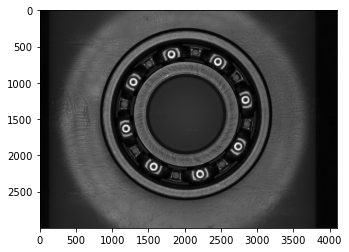

In [27]:
index = 354
rec = data[index]
image_path = image_data_root + rec['info']['image_path']
img = cv.imread(image_path)

center,r_inner,r_outer = getCicleByInfo(rec)
rec_id = rec['info']['uuid']
word_img = False
bbox_list = []
for inst in rec['instances']:
    character_id = inst['uuid']
    class_names = am.get_classname(inst)
    if('word' in class_names):
        word_img = True
        Info = am.get_xyxy(inst)
        bbox = [[Info[0],Info[1]],[Info[2],Info[3]]]
        bbox_list.append(bbox)
print(bbox_list)
plt.imshow(img)

In [26]:
rec

{'info': {'uuid': '90ab314cc5d411eb87d27d5754f0dc11',
  'image_path': 'data/2021-05-26/202/ok/1750/1_2.png',
  'height': 3000,
  'width': 4096,
  'roi': [0, 0, 3000, 4096],
  'parent_uuid': '90ab314cc5d411eb87d27d5754f0dc11',
  'imaging': '2',
  'circles': [[2015.6541748046875, 1434.27392578125, 556.6614990234375],
   [2016.7581787109375, 1433.4609375, 720.4082641601562],
   [2015.5235595703125, 1434.26904296875, 1041.507568359375],
   [2015.8826904296875, 1435.375, 1143.8009643554688],
   [2017.9971923828125, 1435.2984619140625, 1179.762939453125]]},
 'instances': [{'uuid': '8a9cd276c7f911ebb0d2ea1702ca848e',
   'distribution': '0,1,0,0,0,0,0,0,0,0,0,0',
   'shape_type': 'polygon',
   'points': '2532.000000+2340.000000,2561.000000+2340.000000,2561.000000+2416.000000,2532.000000+2416.000000'}]}

In [17]:
len(word_list)

335

In [18]:
word_list

['data/2021-05-26/202/ok/1572/1_2.png',
 'data/2021-05-26/202/ok/1573/1_2.png',
 'data/2021-05-26/202/ok/1574/1_2.png',
 'data/2021-05-26/202/ok/1575/1_2.png',
 'data/2021-05-26/202/ok/1576/1_2.png',
 'data/2021-05-26/202/ok/1577/1_2.png',
 'data/2021-05-26/202/ok/1578/2_1.png',
 'data/2021-05-26/202/ok/1579/1_2.png',
 'data/2021-05-26/202/ok/1580/2_1.png',
 'data/2021-05-26/202/ok/1581/1_2.png',
 'data/2021-05-26/202/ok/1582/1_2.png',
 'data/2021-05-26/202/ok/1583/1_2.png',
 'data/2021-05-26/202/ok/1584/1_2.png',
 'data/2021-05-26/202/ok/1585/1_2.png',
 'data/2021-05-26/202/ok/1586/1_2.png',
 'data/2021-05-26/202/ok/1587/1_2.png',
 'data/2021-05-26/202/ok/1588/1_2.png',
 'data/2021-05-26/202/ok/1589/1_2.png',
 'data/2021-05-26/202/ok/1590/1_2.png',
 'data/2021-05-26/202/ok/1591/1_2.png',
 'data/2021-05-26/202/ok/1592/2_1.png',
 'data/2021-05-26/202/ok/1593/1_2.png',
 'data/2021-05-26/202/ok/1594/2_1.png',
 'data/2021-05-26/202/ok/1595/1_2.png',
 'data/2021-05-26/202/ok/1596/1_2.png',


### 单图测试

In [ ]:
#index 为11 修改r_inner,r_outer
index = 11
img = img_list[index]
bbox_list = get_bbox_list(img_json_path,index)
r_inner,r_outer,center = get_radius_center(img)
fig = plt.figure(figsize=(12,12))
ring_obj = Ring_Processer(img)
circles = ring_obj.circle_list
r_inner = circles[0][2]
r_outer = circles[1][2]
plt.imshow(img)

# index = 6
# img = img_list[index]
# bbox_list = get_bbox_list(img_json_path,index)
# r_inner,r_outer,center = get_radius_center(img)
# fig = plt.figure(figsize=(12,12))
# plt.imshow(img)

distribution_classes = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
weights_path = "./models/resnet34.pt"
word_classifier = Word_Classification(weights_path,distribution_classes)
start = time.time()
pattern_list = ["6202/P6","B"]  
is_ng, result = word_classifier.get_str_matchInfo(img,bbox_list,r_inner,r_outer,center,pattern_list)
end = time.time()
print(end-start)
print(result)

img0 = img.copy()
for xyxy in result["str_bbox_list"]:
    xy_min = [int(xyxy[0]),int(xyxy[1])]
    xy_max = [int(xyxy[2]),int(xyxy[3])]
    img0 = cv2.rectangle(img0, xy_min,xy_max, (0,0,255), 10)
plt.imshow(img0)

"""
index:3 ; result: ['6001IPBLTB', 'QZ21D2', '6SNV', 'BH']  较多错误
index:4 ; result: ['69LP6']        连接
index:5 ; result: ['B', '690SNP6'] 5->s
index:6 ; result: ['6001IPBL7B', '2221D2', '6ON1', 'BH']  6->B T->7 0->N
"""

In [1]:
import os
image_path = "F:/mountMl_fan/bearing/data/2021-05-26/202/starving/1821/1_2.png"
file_path, filename = os.path.split(image_path)
# Pfile = image_path.split(os.path.sep)[-3]
print(image_path.split(os.path.sep))

['F:/mountMl_fan/bearing/data/2021-05-26/202/starving/1821/1_2.png']


In [2]:
os.path.sep

'\\'